<a href="https://colab.research.google.com/github/santhiravuri/generative-ai-internship/blob/main/day19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
"""Team-10. Input Conditioning Visualization
->In CGAN,generate each digit class with fixed noise
->compare inter class visual diversity"""
#Conditional GAN on CIFAR-10 (DCGAN style)
# Install required libraries

!pip install -q torchvision matplotlib
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# ---------------------------------------------------
# 1. Load CIFAR-10 Dataset
# ---------------------------------------------------
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

num_classes = 10
img_size = 32
channels = 3
latent_dim = 100
img_shape = (channels, img_size, img_size)


100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


In [17]:
# ---------------------------------------------------
# 2. Helper: One-hot embedding for labels
# ---------------------------------------------------
def one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels].to(device)

In [18]:
# ---------------------------------------------------
# 3. Generator
# ---------------------------------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 8x8 -> 16x16
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # 16x16 -> 32x32
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [19]:
# ---------------------------------------------------
# 4. Discriminator
# ---------------------------------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Conv2d(channels + num_classes, 64, 4, 2, 1),  # 32x32 -> 16x16
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_map = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)
        label_map = label_map.expand(labels.shape[0], num_classes, img_size, img_size)
        d_in = torch.cat((img, label_map), 1)
        validity = self.model(d_in)
        return validity


In [20]:
# ---------------------------------------------------
# 5. Initialize Models & Optimizers
# ---------------------------------------------------
generator = Generator().to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

[Epoch 1/20] [Batch 0/782] [D loss: 0.7455] [G loss: 0.7063]
[Epoch 1/20] [Batch 200/782] [D loss: 0.6237] [G loss: 0.8308]
[Epoch 1/20] [Batch 400/782] [D loss: 0.6726] [G loss: 0.6985]
[Epoch 1/20] [Batch 600/782] [D loss: 0.6920] [G loss: 0.6622]


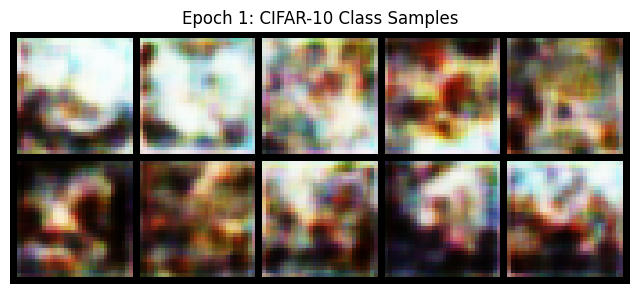

[Epoch 2/20] [Batch 0/782] [D loss: 0.6718] [G loss: 0.7790]
[Epoch 2/20] [Batch 200/782] [D loss: 0.7256] [G loss: 0.6929]
[Epoch 2/20] [Batch 400/782] [D loss: 0.6567] [G loss: 0.7090]
[Epoch 2/20] [Batch 600/782] [D loss: 0.7138] [G loss: 0.6516]
[Epoch 3/20] [Batch 0/782] [D loss: 0.7095] [G loss: 0.7825]
[Epoch 3/20] [Batch 200/782] [D loss: 0.6278] [G loss: 0.7260]
[Epoch 3/20] [Batch 400/782] [D loss: 0.7005] [G loss: 0.6713]
[Epoch 3/20] [Batch 600/782] [D loss: 0.6827] [G loss: 0.7050]
[Epoch 4/20] [Batch 0/782] [D loss: 0.6964] [G loss: 0.7143]
[Epoch 4/20] [Batch 200/782] [D loss: 0.6934] [G loss: 0.7689]
[Epoch 4/20] [Batch 400/782] [D loss: 0.7100] [G loss: 0.6599]
[Epoch 4/20] [Batch 600/782] [D loss: 0.6863] [G loss: 0.6993]
[Epoch 5/20] [Batch 0/782] [D loss: 0.6818] [G loss: 0.7991]
[Epoch 5/20] [Batch 200/782] [D loss: 0.7093] [G loss: 0.6541]
[Epoch 5/20] [Batch 400/782] [D loss: 0.7050] [G loss: 0.6536]
[Epoch 5/20] [Batch 600/782] [D loss: 0.7017] [G loss: 0.6342]


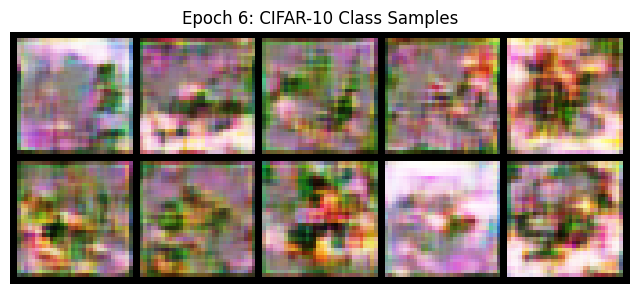

[Epoch 7/20] [Batch 0/782] [D loss: 0.6715] [G loss: 0.8141]
[Epoch 7/20] [Batch 200/782] [D loss: 0.7602] [G loss: 0.6880]
[Epoch 7/20] [Batch 400/782] [D loss: 0.7360] [G loss: 0.5952]
[Epoch 7/20] [Batch 600/782] [D loss: 0.6855] [G loss: 0.7078]
[Epoch 8/20] [Batch 0/782] [D loss: 0.7045] [G loss: 0.6206]
[Epoch 8/20] [Batch 200/782] [D loss: 0.7216] [G loss: 0.6526]
[Epoch 8/20] [Batch 400/782] [D loss: 0.6492] [G loss: 0.6853]
[Epoch 8/20] [Batch 600/782] [D loss: 0.6919] [G loss: 0.6813]
[Epoch 9/20] [Batch 0/782] [D loss: 0.6830] [G loss: 0.6938]
[Epoch 9/20] [Batch 200/782] [D loss: 0.6394] [G loss: 0.8303]
[Epoch 9/20] [Batch 400/782] [D loss: 0.7031] [G loss: 0.6633]
[Epoch 9/20] [Batch 600/782] [D loss: 0.6844] [G loss: 0.6552]
[Epoch 10/20] [Batch 0/782] [D loss: 0.7463] [G loss: 0.7966]
[Epoch 10/20] [Batch 200/782] [D loss: 0.6961] [G loss: 0.6843]
[Epoch 10/20] [Batch 400/782] [D loss: 0.6865] [G loss: 0.6957]
[Epoch 10/20] [Batch 600/782] [D loss: 0.6929] [G loss: 0.68

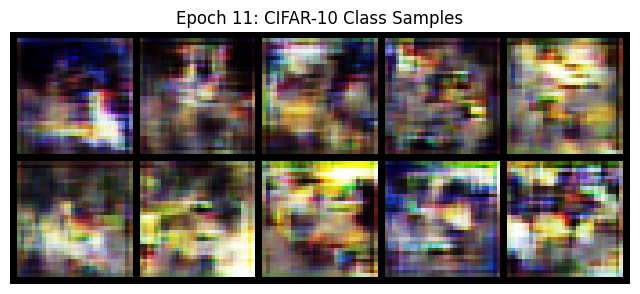

[Epoch 12/20] [Batch 0/782] [D loss: 0.6931] [G loss: 0.7266]
[Epoch 12/20] [Batch 200/782] [D loss: 0.6525] [G loss: 0.6536]
[Epoch 12/20] [Batch 400/782] [D loss: 0.6812] [G loss: 0.6309]
[Epoch 12/20] [Batch 600/782] [D loss: 0.7368] [G loss: 0.7050]
[Epoch 13/20] [Batch 0/782] [D loss: 0.6801] [G loss: 0.7868]
[Epoch 13/20] [Batch 200/782] [D loss: 0.6490] [G loss: 0.7164]
[Epoch 13/20] [Batch 400/782] [D loss: 0.6901] [G loss: 0.7298]
[Epoch 13/20] [Batch 600/782] [D loss: 0.7439] [G loss: 0.6102]
[Epoch 14/20] [Batch 0/782] [D loss: 0.6967] [G loss: 0.6242]
[Epoch 14/20] [Batch 200/782] [D loss: 0.6909] [G loss: 0.6515]
[Epoch 14/20] [Batch 400/782] [D loss: 0.7138] [G loss: 0.7015]
[Epoch 14/20] [Batch 600/782] [D loss: 0.6683] [G loss: 0.7180]
[Epoch 15/20] [Batch 0/782] [D loss: 0.6430] [G loss: 0.7751]
[Epoch 15/20] [Batch 200/782] [D loss: 0.7304] [G loss: 0.5480]
[Epoch 15/20] [Batch 400/782] [D loss: 0.6978] [G loss: 0.6917]
[Epoch 15/20] [Batch 600/782] [D loss: 0.6960] [

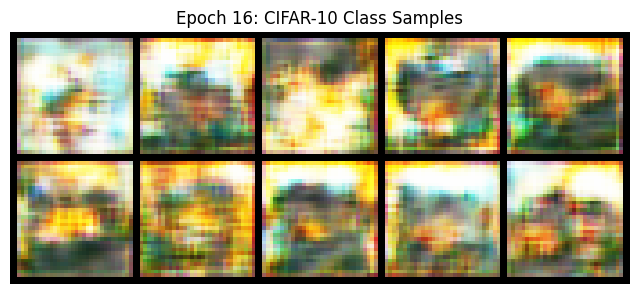

[Epoch 17/20] [Batch 0/782] [D loss: 0.7542] [G loss: 0.6390]
[Epoch 17/20] [Batch 200/782] [D loss: 0.6874] [G loss: 0.6908]
[Epoch 17/20] [Batch 400/782] [D loss: 0.6818] [G loss: 0.6999]
[Epoch 17/20] [Batch 600/782] [D loss: 0.6949] [G loss: 0.7403]
[Epoch 18/20] [Batch 0/782] [D loss: 0.7110] [G loss: 0.7392]
[Epoch 18/20] [Batch 200/782] [D loss: 0.6862] [G loss: 0.6619]
[Epoch 18/20] [Batch 400/782] [D loss: 0.7123] [G loss: 0.6567]
[Epoch 18/20] [Batch 600/782] [D loss: 0.6864] [G loss: 0.6534]
[Epoch 19/20] [Batch 0/782] [D loss: 0.6984] [G loss: 0.6564]
[Epoch 19/20] [Batch 200/782] [D loss: 0.7030] [G loss: 0.7271]
[Epoch 19/20] [Batch 400/782] [D loss: 0.7660] [G loss: 0.5064]
[Epoch 19/20] [Batch 600/782] [D loss: 0.6510] [G loss: 0.7347]
[Epoch 20/20] [Batch 0/782] [D loss: 0.7458] [G loss: 0.6733]
[Epoch 20/20] [Batch 200/782] [D loss: 0.6648] [G loss: 0.6670]
[Epoch 20/20] [Batch 400/782] [D loss: 0.7050] [G loss: 0.6401]
[Epoch 20/20] [Batch 600/782] [D loss: 0.7080] [

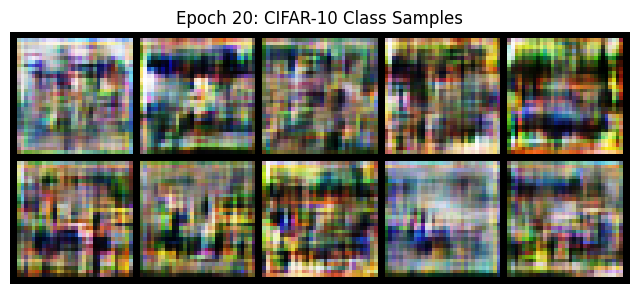

In [22]:
# ---------------------------------------------------
# 6. Training Loop
# ---------------------------------------------------
epochs = 20
sample_interval = 5

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---- Train Generator ----
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 200 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # ---- Save Sample Images ----
    if epoch % sample_interval == 0 or epoch == epochs - 1:
        generator.eval()
        z = torch.randn(10, latent_dim).to(device)
        labels = torch.arange(0, 10).to(device)
        gen_imgs = generator(z, labels).detach().cpu()
        gen_imgs = (gen_imgs + 1) / 2  # Normalize to [0, 1]
        grid = vutils.make_grid(gen_imgs, nrow=5)
        plt.figure(figsize=(8, 4))
        plt.imshow(np.transpose(grid, (1, 2, 0)))
        plt.axis("off")
        plt.title(f"Epoch {epoch+1}: CIFAR-10 Class Samples")
        plt.show()
        generator.train()